In [1]:
#!pip install bambi git+https://github.com/yannmclatchie/kulprit.git

In [2]:
import pandas as pd
import numpy as np

import bambi as bmb
import kulprit as kpt

import arviz as az
import matplotlib.pyplot as plt

# define model data
data = pd.DataFrame({
    "y": np.random.normal(size=50),
    "g": np.random.choice(["Yes", "No"], size=50),
    "x1": np.random.normal(size=50),
    "x2": np.random.normal(size=50)
})
# define and fit model with MCMC
model = bmb.Model("y ~ x1 + x2", data, family="gaussian")
num_draws, num_chains = 1_000, 2
posterior = model.fit(draws=num_draws, chains=num_chains)
# build reference model object
proj = kpt.Projector(model, posterior)
# project the reference model to some parameter subset and plot posterior
cov_names = ["x1", "x2"]
theta_perp = proj.project(cov_names=cov_names)

/Users/yannmclatchie/Desktop/kulprit/.venv/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, x2, x1, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
/Users/yannmclatchie/Desktop/kulprit/src/kulprit/families/family.py:73: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/TensorShape.cpp:2318.)
  sigma_ast**2 + 1 / ref_model.num_obs * (f - f_perp).T @ (f - f_perp)


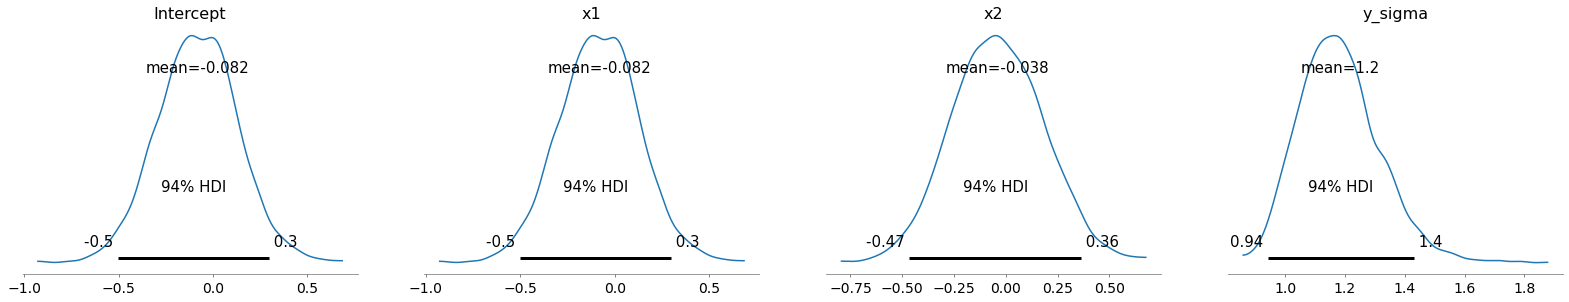

In [3]:
az.plot_posterior(theta_perp.inferencedata)
plt.show()

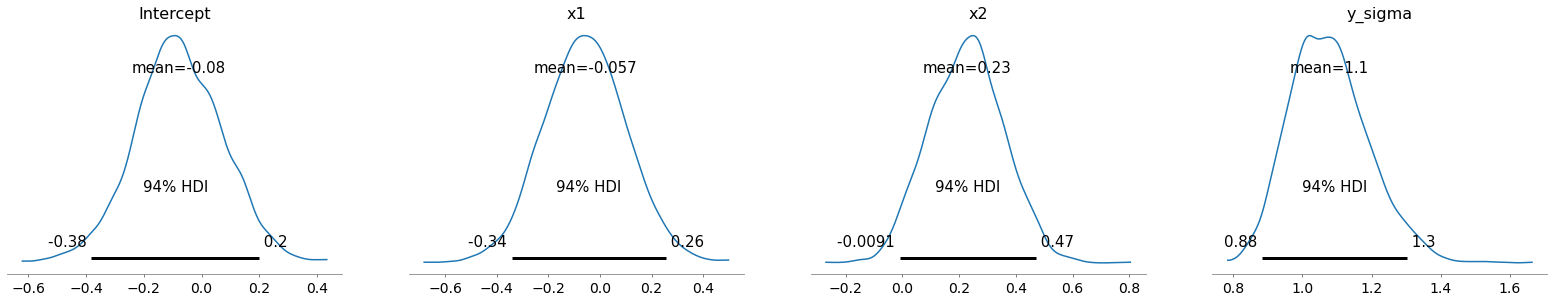

In [4]:
az.plot_posterior(posterior, var_names=["Intercept", "x1", "x2", "y_sigma"])
plt.show()